In [65]:
import torch
import torch.nn as nn
from torch.func import vmap, grad, functional_call  # Nouvelle API PyTorch 2.x
import torch.optim as optim
import vutils

# Modèle simple
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear = nn.Linear(50, 10)
        self.linear2 = nn.Linear(10, 1)

    def forward(self, x):
        output = self.linear(x)
        output = torch.relu(output)
        output = self.linear2(output)
        return output

# Initialisation
model = SimpleModel()
criterion = nn.MSELoss()

# Génération de données
batch_size = 64
x = torch.randn(batch_size, 50)  # Pas besoin de requires_grad=True ici
y = torch.randn(batch_size, 1)

# Dummy model
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(optimizer.state)


for epoch in range(10):
    model.zero_grad()  # Reset gradients
    # Forward and backward pass
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    # Accessing first and second moments
    for param in model.parameters():
        state = optimizer.state[param]
        # print(state)
        if 'exp_avg' in state and 'exp_avg_sq' in state:
            m = state['exp_avg']       # First moment
            v = state['exp_avg_sq']    # Second moment
            # print("First moment (m):", m)
            V = v - m * m + torch.abs(torch.min(v - m * m))
            print(param.grad / torch.sqrt(v))
            



defaultdict(<class 'dict'>, {})
tensor([[-31.6228,  31.6228,  31.6228, -31.6228,  31.6228,  31.6228, -31.6228,
          31.6228, -31.6228,  31.6228,  31.6228, -31.6228, -31.6228, -31.6228,
         -31.6228, -31.6228, -31.6228, -31.6228, -31.6228, -31.6228, -31.6228,
         -31.6228, -31.6228,  31.6228, -31.6228,  31.6228, -31.6228,  31.6228,
          31.6228,  31.6228, -31.6228,  31.6228, -31.6228, -31.6228, -31.6228,
         -31.6228,  31.6228,  31.6228,  31.6228,  31.6228,  31.6228,  31.6228,
         -31.6228,  31.6228,  31.6228, -31.6228, -31.6228, -31.6228, -31.6228,
          31.6228],
        [-31.6228, -31.6228,  31.6228, -31.6228,  31.6228,  31.6228,  31.6228,
         -31.6228, -31.6228,  31.6228,  31.6228, -31.6228, -31.6228, -31.6228,
          31.6228, -31.6228, -31.6228,  31.6228,  31.6228,  31.6228, -31.6228,
          31.6228, -31.6228, -31.6228,  31.6228,  31.6228,  31.6228,  31.6228,
          31.6228, -31.6228, -31.6228, -31.6228, -31.6228, -31.6228, -31.6228,


In [41]:
optimizer.state[0]

{}

In [7]:
import torch

# Example tensor
x = torch.tensor([0.0, 1.0, 2.0])

# Define a standard normal distribution (mean=0, std=1)
normal_dist = torch.distributions.Normal(loc=0.0, scale=1.0)

# Apply the CDF
cdf_values = normal_dist.cdf(x)

print(cdf_values)

tensor([0.5000, 0.8413, 0.9772])


In [17]:
normal_dist = torch.distributions.Normal(loc=0.0, scale=1.0)

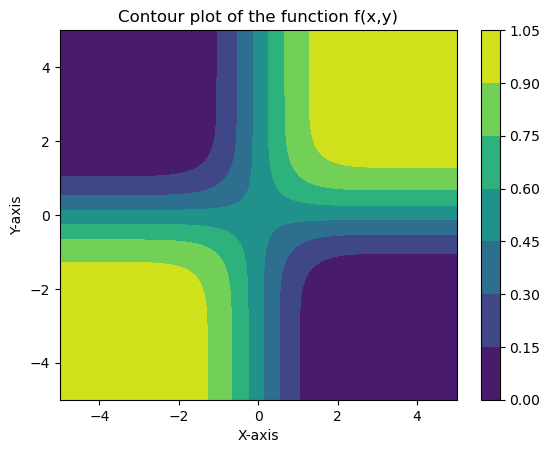

In [23]:

X = torch.linspace(-5, 5, 100)
Y = torch.linspace(-5, 5, 100)

gX = normal_dist.cdf(X)
gY = normal_dist.cdf(Y)

def f(x,y):
    return normal_dist.cdf(x) * normal_dist.cdf(y) + (1 - normal_dist.cdf(x)) * (1 - normal_dist.cdf(y))

import matplotlib.pyplot as plt

[X, Y] = torch.meshgrid(X, Y)
Z = f(X, Y)

plt.contourf(X.numpy(), Y.numpy(), Z.numpy())
plt.colorbar()
plt.title('Contour plot of the function f(x,y)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

